# INF8111 - Fouille de données


## TP2 Automne 2019 - Détection de discours d'incitation à la haine

##### Membres de l'équipe:

    - MAINKA Adrien (2046374)
    - BAKKAOUI Mehdi (2038803)
    - METAIS Marianne (2038757)

In [2]:
import pandas as pd
import re
import string
from nltk.tokenize import word_tokenize
import words_repeated_char
import sys
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")

## 1. Preprocessing

In [10]:
def read_csv(file_path, delimiter = ' '):
    """ We had some issues loading the data using pandas.read_csv, so we built our own loader.
        Read a csv file, returns a pandas.Dataframe
    """
    fp = open(file_path, encoding="utf8")
    line = fp.readline()
    data_dict = dict()
    labels = line[:-1].split(delimiter)
    line = fp.readline()
    for label in labels:
        data_dict[label] = []
    while line:
        for i, j in enumerate(line[:-1].split(delimiter)):
            data_dict[labels[i]].append(j)
        line = fp.readline()
    return pd.DataFrame(data_dict)

In [11]:
data = read_csv("data/hateful_tweets_filtered.csv", delimiter='\t')

In [12]:
data.head()

,tweet_id,label,tweet_content
0,7629505483,abusive,I fuckin hate when niggas stare at me fuck r u...
1,12181574836,abusive,everyone jumps to silly conclusions as soon as...
2,25381445793,abusive,#sincewerebeinghonest I'm Emo. I Need A Fuckin...
3,192730077165916160,abusive,banana bread recipe: 1. get some bread 2. i do...
4,280882735374028800,abusive,godamn this bitch so bad i want 2 drink molly ...


In [13]:
preprocessed = []
for i, tweet in enumerate(data["tweet_content"].values[:]):
    tmp = tweet.lower().replace("\\n",' ').replace('\\xa0', ' ').replace('\\r', ' ').replace("\\'","'").replace("&lt;",'<')\
         .replace("&gt;",'>').replace(" &amp; ", " and ").replace("&amp;", "&")
    # lower the tweet and replacing characters that tweeter has tranlated to their hmtl numeric code to their original value
    tmp = re.sub("(http(s)?://)?(www\.)?([a-zA-Z0-9])+\.[a-z]{1,3}(/\S*)?",'URL', tmp) # 
    tmp = re.sub("#\w+", 'HASHTAG', tmp)
    tmp = re.sub("@\w+", 'USER', tmp)
    tmp = re.sub("\w+@\w+\.[a-z]{2,3}", "EMAIL", tmp)
    tmp = re.sub("[0-9]{1,2}/[0-9]{1,2}/([0-9]{4}|[0-9]{2})|([0-9]{4}|[0-9]{2})/[0-9]{1,2}/[0-9]{1,2}|[0-9]{2}/[0-9]{2}", "DATE", tmp)
    tmp = re.sub("[0-9]{2}(:[0-9]{2}){1,2}( ?(am|pm))?", "TIME", tmp)
    tmp = re.sub("(([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF]))+", ' EMOJI ', tmp)
    tmp = tmp.encode(encoding='ascii', errors='ignore').decode()
    # get rid of the non ascii characters
    tmp = re.sub("\.{2,}", "...", tmp)
    for c in ['!', '-', ',']:
        tmp = re.sub("{}+".format(c), c, tmp)
    tmp = re.sub("\?+", "?", tmp)
    tmp = re.sub("`+", "'", tmp)
    tmp = re.sub("'{2,}", "'", tmp)
    tmp = tmp.translate(str.maketrans(dict.fromkeys('#*+/<=>@[\\]^_`{|}~'))) #removing all the other special characters
    tokens = [t if t not in ["''", "``"] else '"' for t in word_tokenize(tmp) ]
    # tokenizing using nltk.word_tokenize. althought it transforms '"' into '``' or "''" and this is a behaviour do not want
    # so we make sure that the '"' are changed to their original form
    for i, token in enumerate(tokens):
        if re.search(r"([a-z])\1{2,}", token):
            # cleaning the words containing a letter repeated 3 times or more, using the list of the Ensglish words
            tokens[i] = words_repeated_char.clean(token)
    preprocessed.append(tokens)

In [14]:
data["preprocessed"] = preprocessed

In [15]:
data.head()

,tweet_id,label,tweet_content,preprocessed
0,7629505483,abusive,I fuckin hate when niggas stare at me fuck r u...,"[i, fuckin, hate, when, niggas, stare, at, me,..."
1,12181574836,abusive,everyone jumps to silly conclusions as soon as...,"[everyone, jumps, to, silly, conclusions, as, ..."
2,25381445793,abusive,#sincewerebeinghonest I'm Emo. I Need A Fuckin...,"[HASHTAG, i, 'm, emo, ., i, need, a, fucking, ..."
3,192730077165916160,abusive,banana bread recipe: 1. get some bread 2. i do...,"[banana, bread, recipe, :, 1., get, some, brea..."
4,280882735374028800,abusive,godamn this bitch so bad i want 2 drink molly ...,"[godamn, this, bitch, so, bad, i, want, 2, dri..."


## 2. Jeu de données

In [69]:
from sklearn.model_selection import train_test_split

X = preprocessed
y = []


for i in range(len(data)):
    
    if data["label"][i] == "hateful":
        y.append(0)
    elif data["label"][i] == "abusive":
        y.append(1)
    elif data["label"][i] == "spam":
        y.append(2)
    elif data["label"][i] == "normal":
        y.append(3)

train_valid_X, test_X, train_valid_Y, test_Y = train_test_split(X, y, test_size=0.15, random_state=12)

train_X, valid_X, train_Y, valid_Y = train_test_split(train_valid_X, train_valid_Y, test_size=0.18, random_state=12)

print("Length of training set : ", len(train_X))
print("Length of validation set : ", len(valid_X))
print("Length of test set : ", len(test_X))

Length of training set :  42056
Length of validation set :  9233
Length of test set :  9052


## 3. Stemming

In [120]:
from nltk.stem.snowball import SnowballStemmer


class Stemmer(object):

    def __init__(self):
        self.stemmer = SnowballStemmer("english", ignore_stopwords=True)

    def stem(self, tweet):
        """
        tweet: a list of string
        """
        # Have to return the stemmed tweet
        return list(map(self.stemmer.stem , tweet))



In [121]:
s=Stemmer()
X = list(map(s.stem, X))

## 4. N-grams

In [23]:
def bigram(tokens):
    """
    tokens: a list of strings
    """
    # This function returns the list of bigrams
    if len(tokens) < 2:
        return []
    bigrams = []
    previous_word = tokens[0]
    for word in tokens[1:]:
        bigrams.append(previous_word + " " + word)
        previous_word = word
    return bigrams


def trigram(tokens):
    """
    tokens: a list of strings
    """
    # This function returns the list of trigrams
    if len(tokens) < 3:
        return []
    trigrams = []
    previous_word = tokens[1]
    previous_previous_word = tokens[0]
    for word in tokens[2:]:
        trigrams.append(previous_previous_word + " " + previous_word + " " + word)
        previous_previous_word = previous_word
        previous_word = word
    return trigrams

## 5. Bag-of-words

In [123]:
from scipy.sparse import csr_matrix, lil_matrix
import numpy as np

class CountBoW(object):

    def __init__(self, bigram=False, trigram=False):
        """
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        words: list of words in the vocabulary
        """
        self.bigram = bigram
        self.trigram = trigram
        self.words = None
        

    def computeBoW(self, tokens):
        """
        Calcule du BoW, à partir d'un dictionnaire de mots et d'une liste de tweets.
        On suppose que l'on a déjà collecté le dictionnaire sur l'ensemble d'entraînement.
        
        Entrée: tokens, une liste de vecteurs contenant les tweets (une liste de liste)
        
        Return: une csr_matrix
        """
        
        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )
        
        bow = lil_matrix((len(tokens), len(self.words)))

        for i, tweet in enumerate(tokens):
            for token in tweet:
                if token in self.words:
                    bow[i, self.words.index(token)] += 1
        
        BoW = csr_matrix(bow)
        return BoW
                

    def fit_transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs d'entiers.
        
        Entrée: X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """
        tokens = X
        
        tokens_bi_tri = list(tokens)
            
        if self.bigram:
            for i, tweet in enumerate(tokens):
                tokens_bi_tri[i] = tokens_bi_tri[i] + bigram(tweet)
        
        if self.trigram:
            for i, tweet in enumerate(tokens):
                tokens_bi_tri[i] = tokens_bi_tri[i] + trigram(tweet)
                
        words = []
        for tweet in tokens_bi_tri:
            for token in tweet:
                if token not in words:
                    words.append(token)

        self.words = words
        return self.computeBoW(tokens_bi_tri)
        
    
    def transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs d'entiers.
        Différence avec fit_transform : on suppose qu'on dispose déjà du dictionnaire ici

        Entrée: X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """
        
        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )

        tokens = X
        tokens_bi_tri = list(tokens)
        if self.bigram:
            for i, tweet in enumerate(tokens):
                tokens_bi_tri[i] = tokens_bi_tri[i] + bigram(tweet)
        
        if self.trigram:
            print("bow tfidf")
            for i, tweet in enumerate(tokens):
                tokens_bi_tri[i] = tokens_bi_tri[i] + trigram(tweet)
        
        return self.computeBoW(tokens_bi_tri)

## 6. TF-IDF

In [129]:
from scipy.sparse import csr_matrix, csc_matrix
import math


class TFIDFBoW(object):

    def __init__(self, bigram=False, trigram=False):
        """
        bigram: enable or disable bigram
        trigram: enable or disable trigram
        words: list of words in the vocabulary
        idf: list of idfs for each document
        """
        self.bigram = bigram
        self.trigram = trigram
        self.words = None
        self.idf = None
        
        self.cBoW = None
    
    def computeTFIDF(self, X):
        """
        Calcule du TF-IDF, à partir d'un dictionnaire de mots et d'une 
        liste de tweets.
        On suppose que l'on a déjà collecté le dictionnaire ainsi que 
        calculé le vecteur contenant l'idf pour chaque document.
        
        Entrée : X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """
        print("computeTFIDF...")
        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )
        
        tf = self.cBoW.computeBoW(X)
                
        for j in range(len(X)):
            tf[j] = tf[j].multiply(self.idf)
                
        TFIDF = csr_matrix(tf)
        return TFIDF


    def fit_transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs de flottants avec la pondération TF-IDF.
        
        Entrée : X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """
        print("fit_transform...")
        
        tokens = X
        
        print("compute bow...")
        
        cBoW = CountBoW(bigram = self.bigram, trigram = self.trigram)
        bow = cBoW.fit_transform(X)
        self.cBoW = cBoW
        
        self.words = cBoW.words

        print("compute idf...")
        df = np.diff(bow.tocsc().indptr)
        df = (list(map(lambda x: math.log(len(X)/x), df)))
        self.idf = df
        
        tokens_bi_tri = list(tokens)
        if self.bigram:
            for i, tweet in enumerate(tokens):
                tokens_bi_tri[i] = tokens_bi_tri[i] + bigram(tweet)
        
        if self.trigram:
            for i, tweet in enumerate(tokens):
                tokens_bi_tri[i] = tokens_bi_tri[i] + trigram(tweet)
        
        return self.computeTFIDF(tokens_bi_tri)

    def transform(self, X):
        """
        Cette méthode preprocess les données en utilisant la pipeline, ajoute les bigram et trigram 
        si besoin, et transforme les textes en vecteurs de flottants avec la pondération TF-IDF.
        Différence avec fit_transform : on suppose qu'on dispose déjà du dictionnaire et du calcul des idf ici.
            
        Entrée : X, une liste de vecteurs contenant les tweets
        
        Return: une csr_matrix
        """
        print("transform")

        if self.words is None:
            raise Exception(
                "fit_transform() should be called first (no dictionnary available)"
            )

        tokens = X
        tokens_bi_tri = list(tokens)
        if self.bigram:
            for i, tweet in enumerate(tokens):
                tokens_bi_tri[i] = tokens_bi_tri[i] + bigram(tweet)
        
        if self.trigram:
            for i, tweet in enumerate(tokens):
                tokens_bi_tri[i] = tokens_bi_tri[i] + trigram(tweet)
        
        return self.computeTFIDF(tokens_bi_tri)

## 7. Classification

In [126]:
import numpy as np
from sklearn.metrics import accuracy_score


def train_evaluate(classifier, training_X, training_Y, validation_X, validation_Y, bowObj):
    """
    classifier: model used (LogisticRegression...)
    training_X: tweets from the training dataset
    training_Y: tweet labels from the training dataset
    validation_X: tweets from the validation dataset
    validation_Y: tweet labels from the validation dataset
    bowObj: Bag-of-word object
    
    :return: the classifier and its accuracy in the training and validation dataset.
    """

    training_rep = bowObj.fit_transform(training_X)

    classifier.fit(training_rep, training_Y)

    trainAcc = accuracy_score(training_Y, classifier.predict(training_rep))
    validationAcc = accuracy_score(
        validation_Y, classifier.predict(bowObj.transform(validation_X)))

    return classifier, trainAcc, validationAcc

In [131]:
trainAcc = []
validationAcc = []

# LogisticRegression + TFIDFBoW + unigram
tb = TFIDFBoW(bigram = False,trigram = False)
model=train_evaluate(LogisticRegression(n_jobs=-1),test_X, test_Y, valid_X, valid_Y, tb)
trainAcc.append(model[1])
validationAcc.append(model[2])

fit_transform...
compute bow...
compute idf...
computeTFIDF...


C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\mehdi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1297: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


transform
computeTFIDF...


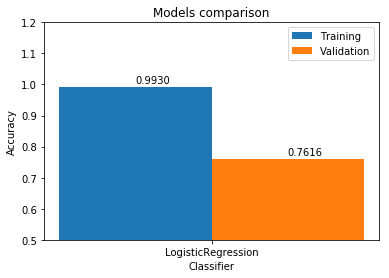

In [139]:
import matplotlib.pyplot as plt

r=np.arange(len(trainAcc))

TypeAcc = ["Training", "Validation"]
bar_width = 0.35

plt.bar(r, trainAcc,bar_width)
plt.bar(r+bar_width, validationAcc,bar_width)
plt.xticks(r+bar_width/2, ['LogisticRegression', '2', '3', '4', '5', '6'])

plt.xlabel('Classifier')
plt.ylabel('Accuracy')

plt.title('Models comparison')

plt.legend(TypeAcc)

for i in range(len(trainAcc)):
    plt.text(x = r[i] , y = trainAcc[i]+0.01, s = '%.4f' % trainAcc[i])
    plt.text(x = r[i]+bar_width , y = validationAcc[i]+0.01, s = '%.4f' % validationAcc[i])

plt.ylim(.5, 1.2)
plt.show()